In [58]:
import pandas as pd
import numpy as np 
from itertools import permutations, combinations
import math
import random

In [59]:
#generate a tree to obtain a additive distance matrix 

class Vertex:
    def __init__(self, node):
        self.id = node
        self.adjacent = {}

    def __str__(self):
        return str([x.id for x in self.adjacent])

    def add_neighbor(self, neighbor, weight=0):
        self.adjacent[neighbor] = weight

    def get_connections(self):
        return self.adjacent.keys()  

    def get_id(self):
        return self.id

    def get_weight(self, neighbor):
        return self.adjacent[neighbor]

class MatrixTree:
    def __init__(self):
        self.vert_dict = {}
        self.num_vertices = 0

    def __iter__(self):
        return iter(self.vert_dict.values())

    def add_vertex(self, node):
        self.num_vertices = self.num_vertices + 1
        new_vertex = Vertex(node)
        self.vert_dict[node] = new_vertex
        return new_vertex

    def get_vertex(self, n):
        if n in self.vert_dict:
            return self.vert_dict[n]
        else:
            return None

    def add_edge(self, frm, to, cost = 0):
        if frm not in self.vert_dict:
            self.add_vertex(frm)
        if to not in self.vert_dict:
            self.add_vertex(to)

        self.vert_dict[frm].add_neighbor(self.vert_dict[to], cost)
        self.vert_dict[to].add_neighbor(self.vert_dict[frm], cost)

    def get_vertices(self):
        return self.vert_dict.keys()

In [60]:
def get_tree():   
    output = (np.array([random.randrange(1, 10) for _ in range(0, 5)]))

    #generate n+1 random edge weights where n = # of nodes + a weight for a connecting branch

    t = MatrixTree()

    t.add_vertex('a')
    t.add_vertex('b')
    t.add_vertex('c')
    t.add_vertex('d')

    t.add_edge('a', 'b', output[0] + output[1])   #dist between a to b
    t.add_edge('a', 'c', output[0] + output[4] + output[2]) #distance between a, connecting limb, c
    t.add_edge('a', 'd', output[0] + output[4] + output[3]) 
    t.add_edge('b', 'c', output[1] + output[4] + output[2])
    t.add_edge('b', 'd', output[1] + output[4] + output[3])
    t.add_edge('c', 'd', output[2] + output[3])
    return t

In [61]:
# get dict of dicts for each node, neighbors, distance to neighbors 
def get_matrix(tree):
    D = {}
    for v in tree:
        vid = v.get_id()
        D[vid] = {vid : 0} # assign distance from itself to 0
        for w in v.get_connections():
            wid = w.get_id()
            D[vid][wid] = int(v.get_weight(w))
    return D

In [62]:
mat= pd.DataFrame.from_dict(get_matrix(get_tree())) #convert to 2d matrix
#visualize as n x n distance matrix         
mat

,a,b,c,d
a,0,11,23,18
b,11,0,22,17
c,23,22,0,11
d,18,17,11,0


In [63]:
#check if the matrix is additive using four point condition
def is_additive(matrix, labels):
    i = labels[0]
    j = labels[1] 
    k = labels[2] 
    l = labels[3] 
    result = ''
    if ((matrix[i][j] + matrix[k][l] <= matrix[i][k] + matrix[j][l]) and 
    (matrix[i][k] + matrix[j][l] == matrix[i][l] + matrix[j][k])):
        result = "Additive"
    else:
        result = "Not additive"
    return result 

labels = ['a','b','c','d']
is_additive(mat, labels)

'Additive'

## Neigbor join

In [64]:
from ete3 import Tree
import copy
clusters = []
for cluster in list(dm):
    clusters.append(cluster)
cluster2idx = { name : idx for idx, name in enumerate(clusters) }
idx2cluster = copy.deepcopy(clusters)
m = copy.deepcopy(dm).to_dict()
Z = np.empty((0,4), float)
result = ""
print(clusters)
#membership = [set([cluster2idx[name]]) for name in clusters]

NameError: name 'dm' is not defined

In [65]:
import copy
def NJ(dm):
    edge_list = []
    clusters = []
    for cluster in list(dm):
        clusters.append(cluster)
    cluster2idx = { name : idx for idx, name in enumerate(clusters) }
    idx2cluster = copy.deepcopy(clusters)
    m = copy.deepcopy(dm).to_dict()
    result = ""
    M, N = dm.shape
    new_cluster_idx = M+1 
    while len(clusters) > 1:
        idx1 = None
        idx2 = None
        ui = 0
        uj = 0
        Sd = 100000
        for i in clusters:
            for j in clusters:
                if i != j:
                    ui_t = sum(m[i][k] for k in clusters)
                    uj_t = sum(m[j][k] for k in clusters)
                    curr = (M - 2) * m[i][j] - ui_t - uj_t
                    if Sd > curr:
                        Sd = curr
                        idx1 = cluster2idx[i]
                        idx2 = cluster2idx[j]
                        ui = ui_t
                        uj = uj_t

        Dij = m[idx2cluster[idx1]][idx2cluster[idx2]]
        new_cluster = "(" + idx2cluster[idx1] +"." + idx2cluster[idx2] + ")"
        result = new_cluster
        m[new_cluster] = {}
        new_cluster_idx += 1

        if M - 2 != 0:            
            m[idx2cluster[idx1]][new_cluster] = (float(m[idx2cluster[idx1]][idx2cluster[idx2]]) + (1/(M-2)) * (ui - uj))/2
            m[idx2cluster[idx2]][new_cluster] = (float(m[idx2cluster[idx1]][idx2cluster[idx2]]) + (1/(M-2)) * (uj - ui))/2
            edge_list.append((new_cluster, idx2cluster[idx1], m[idx2cluster[idx1]][new_cluster]))
            edge_list.append((new_cluster, idx2cluster[idx2], m[idx2cluster[idx2]][new_cluster]))
        else:
            edge_list.append((idx2cluster[idx1], idx2cluster[idx2], m[idx2cluster[idx1]][idx2cluster[idx2]]))

        clusters.remove(idx2cluster[idx1])
        clusters.remove(idx2cluster[idx2])

        m[new_cluster][new_cluster] = 0
        for c in clusters:
            m[c][new_cluster] = (m[c][idx2cluster[idx1]] + m[c][idx2cluster[idx2]] - Dij)/2
            m[new_cluster][c] = m[c][new_cluster]
#             try:
#                 T[c][new_cluster] = {new_cluster:(m[c][idx2cluster[idx1]] + m[c][idx2cluster[idx2]] - Dij)/2}
#             except:
#                 T[c] = {}
#                 T[c][new_cluster] = {idx2cluster:(m[c][idx2cluster[idx1]] + m[c][idx2cluster[idx2]] - Dij)/2}
            for k in list(m[c].keys()):
                if k == idx2cluster[idx1] or k == idx2cluster[idx2]:
                    del m[c][k]

        del cluster2idx[idx2cluster[idx1]]
        del cluster2idx[idx2cluster[idx2]]
        if idx2cluster[idx1] in m: del m[idx2cluster[idx1]]
        if idx2cluster[idx2] in m: del m[idx2cluster[idx2]]

        clusters.append(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        #print("current tree", T)
        #print("current matrix", m)
        M -= 1
        N -= 1
    return result, edge_list

In [66]:
import ete3
from ete3 import Tree
tree = {'A': {'A': 0, 'B': 6, 'C': 6, 'D': 8},
 'B': {'A': 6, 'B': 0, 'C': 8, 'D': 2},
 'C': {'A': 6, 'B': 8, 'C': 0, 'D': 10},
 'D': {'A': 8, 'B': 2, 'C': 10, 'D': 0}}
dm1 = pd.DataFrame.from_dict(tree)
dm1['A']['B'] = 4
dm1['B']['A'] = 4
dm1['A']['C'] = 10
dm1['C']['A'] = 10
dm1['A']['D'] = 9
dm1['D']['A'] = 9
dm1['B']['C'] = 8
dm1['C']['B'] = 8
dm1['B']['D'] = 7
dm1['D']['B'] = 7
dm1['C']['D'] = 9
dm1['D']['C'] = 9
nj_result1, nj_list1 = NJ(dm1)
ete_nj_tree = Tree.from_parent_child_table(nj_list1)
print(ete_nj_tree)
print(ete_nj_tree.write())


   /-A
  |
--|--B
  |
  |   /-C
   \-|
      \-D
(A:3,B:1,(C:5,D:4)1:2);


In [67]:
def check_and_find_degenerate(D, cols):
    triplets = permutations(D.index,3)
    for triplet in triplets:
        i,j,k = triplet
        if D[i][j] + D[j][k] == D[i][k]:
            return i,j,k, True
        
    return -1,-1,-1, False
    
def compute_trimming_param(D,cols):
    triplets = permutations(D.index,3)
    min_delta = float('inf')
    best_i,best_j,best_k = -1,-1,-1
    for triplet in triplets:
        i,j,k = triplet
        delta = (D[i][j] + D[j][k] - D[i][k])/2
        if delta > 0 and delta < min_delta:
            min_delta = delta
            best_i,best_j,best_k = i,j,k
            
    return min_delta, best_i,best_j,best_k

def Trim(D, delta):
    D = D - (2*delta)
    for i in D.index:
        D[i][i] = 0
    return D

def additive_phylogeny(D, v, cols):
    if D.shape == (2,2):
        T = {D.index[0] : {D.index[1]: D[D.index[0]][D.index[1]]}, 
             D.index[1] : {D.index[0]: D[D.index[1]][D.index[0]]}}
        return T
    i,j,k,flag = check_and_find_degenerate(D, cols)
    if not flag:
        delta,best_i,best_j,best_k = compute_trimming_param(D, cols)
        i,j,k = best_i,best_j,best_k
        D = Trim(D, delta)
    else:
        delta = 0
    #print(flag)
    x = D[i][j]
    D = D.drop([j])
    D = D.drop(j, axis=1)
    T = additive_phylogeny(D, v+1, cols)
    T[v] = {i:x}
    T[i] = {v:x}
    #print(T)
    if v + 1 in T:
        del T[v+1][i]
        
        leftover = 0
        curr_v = v
        while k not in T[curr_v].keys():
            curr_v += 1
        final_v = curr_v
        curr_v = v
        leftover = 0
        while curr_v+2 < final_v:
            leftover += T[curr_v+1][curr_v+2]
            curr_v += 1
        leftover += T[final_v][k]
        T[v][v+1] = D[i][k]-x-leftover
        T[v+1][v] = D[i][k]-x-leftover
    else:
        T[v][k] = D[i][k]-x
        T[k] = {v:D[i][k]-x}
    
    T[v][j] = 0
    T[j] = {v:0}
    for l in T:
        if l in D.index and j in D.index and T[l][v] != D[l][j]:
            print('Matrix not additive')
            return
    for v in T:
        for l in cols:
            if l in T[v] and type(v) == int:
                T[l][v] =  T[l][v] + (delta)
                T[v][l] =  T[v][l] + (delta)
            
    return T

def degen_triples(D):
    cols = ''
    for i in D.index:
        cols += i
    
    return additive_phylogeny(D, 0, cols)

def create_edge_list(T):
    edge_list = []
    for v1 in T:
        for v2 in T[v1]:
            if type(v1) == int and (v1,v2,T[v1][v2]) not in edge_list and (v2,v1,T[v2][v1]) not in edge_list:
                edge_list.append((v1,v2, T[v1][v2]))
    return edge_list


In [68]:
def check_matrix(newick_string, original_matrix):
    import pandas as pd
    import itertools
    from Bio import Phylo
    import io
    
    treedata = newick_string
    handle = io.StringIO(treedata)
    t = Phylo.read(handle, "newick")
    d = {}
    for x, y in itertools.combinations(t.get_terminals(), 2):
        v = t.distance(x, y)
        d[x.name] = d.get(x.name, {})
        d[x.name][y.name] = v
        d[y.name] = d.get(y.name, {})
        d[y.name][x.name] = v
    for x in t.get_terminals():
        d[x.name][x.name] = 0

    m = pd.DataFrame(d)
    return m == original_matrix

In [69]:
not_additive_tree = {'A': {'A': 0, 'B': 6, 'C': 6, 'D': 8},
                    'B': {'A': 6, 'B': 0, 'C': 8, 'D': 2},
                    'C': {'A': 6, 'B': 8, 'C': 0, 'D': 10},
                    'D': {'A': 8, 'B': 2, 'C': 10, 'D': 0}}
not_additive_matrix = pd.DataFrame.from_dict(not_additive_tree)

additive_tree1 = {'A': {'A': 0, 'B': 4, 'C': 10, 'D': 9},
                    'B': {'A': 4, 'B': 0, 'C': 8, 'D': 7},
                    'C': {'A': 10, 'B': 8, 'C': 0, 'D': 9},
                    'D': {'A': 9, 'B': 7, 'C': 9, 'D': 0}}
additive_matrix1 = pd.DataFrame.from_dict(additive_tree1)

big_tree = {'A': {'A': 0, 'B': 3, 'C': 7, 'D': 9, 'E': 2},
        'B': {'A': 3, 'B': 0, 'C': 6, 'D': 8, 'E': 1},
        'C': {'A': 7, 'B': 6, 'C': 0, 'D': 6, 'E': 5},
        'D': {'A': 9, 'B': 8, 'C': 6, 'D': 0, 'E': 7},
        'E': {'A': 2, 'B': 1, 'C': 5, 'D': 7, 'E': 0}}
big_dm = pd.DataFrame.from_dict(big_tree)

big_tree2 = {'A': {'A': 0, 'B': 10, 'C': 17, 'D': 16, 'E': 16},
             'B': {'A': 10, 'B': 0, 'C': 15, 'D': 14, 'E': 14},
             'C': {'A': 17, 'B': 15, 'C': 0, 'D': 9, 'E': 15},
             'D': {'A': 16, 'B': 14, 'C': 9, 'D': 0, 'E': 14},
             'E': {'A': 16, 'B': 14, 'C': 15, 'D': 14, 'E': 0}}

big_dm2 = pd.DataFrame.from_dict(big_tree2)


In [71]:
from ete3 import Tree
mat = pd.DataFrame.from_dict(get_matrix(get_tree()))
T = degen_triples(mat)
print(mat)
ete_dt_tree = Tree.from_parent_child_table(create_edge_list(T))
print(ete_dt_tree)
print(ete_dt_tree.write())
nj_result, nj_list = NJ(mat)
ete_nj_tree = Tree.from_parent_child_table(nj_list)
print(ete_nj_tree)
print(ete_nj_tree.write())
print(check_matrix(ete_dt_tree.write(), mat))
print(check_matrix(ete_nj_tree.write(), mat))
print('distance: ' + str(ete_dt_tree.robinson_foulds(ete_nj_tree,unrooted_trees=True)[0]))
#ete_nj_tree.show()

    a   b   c   d
a   0   8  12  10
b   8   0  14  12
c  12  14   0   8
d  10  12   8   0

   /-b
  |
--|--c
  |
  |   /-a
   \-|
      \-d
(b:5,c:9,(a:7,d:3)1:-4);

   /-a
  |
--|--b
  |
  |   /-c
   \-|
      \-d
(a:3,b:5,(c:5,d:3)1:4);
      a      b     c      d
a  True   True  True   True
b  True   True  True  False
c  True   True  True   True
d  True  False  True   True
      a     b     c     d
a  True  True  True  True
b  True  True  True  True
c  True  True  True  True
d  True  True  True  True
distance: 2


In [72]:
def is_additive_matrix(mat):
    cols = ''
    for i in mat.index:
        cols += i
    labels = permutations(cols,4)
    check = []
    for combs in labels:
        new_label = []
        for item in combs:
            new_label.append(item)
        check.append(is_additive(mat, new_label))
        if is_additive(mat, new_label) == 'Not additive':
            print('fml', new_label)
        else:
            print('ok', new_label)
    print(check)

In [73]:
mat = get_matrix(get_tree())
mat = pd.DataFrame.from_dict(big_tree)

In [74]:
from phylogeny import DistanceMatrix
d = DistanceMatrix(mat, names=('A', 'B', 'C', 'D', 'E'))
d.is_additive()

True

In [75]:

big_tree2 = {'A': {'A': 0, 'B': 10, 'C': 17, 'D': 16, 'E': 16},
             'B': {'A': 10, 'B': 0, 'C': 15, 'D': 14, 'E': 14},
             'C': {'A': 17, 'B': 15, 'C': 0, 'D': 9, 'E': 15},
             'D': {'A': 16, 'B': 14, 'C': 9, 'D': 0, 'E': 14},
             'E': {'A': 16, 'B': 14, 'C': 15, 'D': 14, 'E': 0}}

In [76]:
import phylogeny

In [77]:
mat = get_matrix(get_tree())
mat = pd.DataFrame.from_dict(big_tree)

In [78]:
def additive_phylogeny(D, v, cols):
    if D.shape == (2,2):
        T = {D.index[0] : {D.index[1]: D[D.index[0]][D.index[1]]}, 
             D.index[1] : {D.index[0]: D[D.index[1]][D.index[0]]}}
        return T
    i,j,k,flag = check_and_find_degenerate(D, cols)
    if not flag:
        delta,best_i,best_j,best_k = compute_trimming_param(D, cols)
        i,j,k = best_i,best_j,best_k
        print(D)
        D = Trim(D, delta)
        print(D)
        print(i,j,k)
    else:
        delta = 0
    #print(flag)
    print(D[i][j], D[j][k], D[i][k])
    x = D[i][j]
    D = D.drop([j])
    D = D.drop(j, axis=1)
    T = additive_phylogeny(D, v+1, cols)
    #print('way befoer', T)
    #print(v)
    #print(i,j,k,x)
    T[v] = {i:x}
    T[i] = {v:x}
    print(T)
    if v + 1 in T:
        del T[v+1][i]
        
        leftover = 0
        curr_v = v
        while k not in T[curr_v].keys():
            curr_v += 1
        final_v = curr_v
        curr_v = v
        leftover = 0
        while curr_v+2 < final_v:
            leftover += T[curr_v+1][curr_v+2]
            curr_v += 1
        leftover += T[final_v][k]
        #print('yes baby', D[i][k], x, leftover)
        T[v][v+1] = D[i][k]-x-leftover
        T[v+1][v] = D[i][k]-x-leftover
    else:
        T[v][k] = D[i][k]-x
        T[k] = {v:D[i][k]-x}
    
    T[v][j] = 0
    T[j] = {v:0}
    for l in T:
        if l in D.index and j in D.index and T[l][v] != D[l][j]:
            print('Matrix not additive')
            return
    for v in T:
        for l in cols:
            if l in T[v] and type(v) == int:
                T[l][v] =  T[l][v] + (delta)
                T[v][l] =  T[v][l] + (delta)
            
    return T

def degen_triples(D):
    cols = ''
    for i in D.index:
        cols += i
    
    return additive_phylogeny(D, 0, cols)

In [79]:
#ete_dt_tree = Tree.from_parent_child_table(create_edge_list(degen_triples(mat)))
T = degen_triples(mat)
#nj_result, nj_list = NJ(mat)
#ete_nj_tree = Tree.from_parent_child_table(nj_list)
#print(ete_nj_tree)
#print(ete_nj_tree.write())
#ete_nj_tree.show()
T

2 1 3
   A  B  C  D
A  0  3  7  9
B  3  0  6  8
C  7  6  0  6
D  9  8  6  0
     A    B    C    D
A  0.0  1.0  5.0  7.0
B  1.0  0.0  4.0  6.0
C  5.0  4.0  0.0  4.0
D  7.0  6.0  4.0  0.0
A B C
1.0 4.0 5.0
     A    C    D
A  0.0  5.0  7.0
C  5.0  0.0  4.0
D  7.0  4.0  0.0
     A    C    D
A  0.0  3.0  5.0
C  3.0  0.0  2.0
D  5.0  2.0  0.0
A C D
3.0 2.0 5.0
{'A': {2: 3.0}, 'D': {'A': 5.0}, 2: {'A': 3.0}}
{'A': {1: 1.0}, 'D': {2: 3.0}, 2: {'A': 4.0, 'D': 3.0, 'C': 1.0}, 'C': {2: 1.0}, 1: {'A': 1.0}}
{'A': {0: 2}, 'D': {2: 4.0}, 2: {'D': 4.0, 'C': 2.0, 1: 3.0}, 'C': {2: 2.0}, 1: {'A': 2.0, 2: 3.0, 'B': 1.0}, 'B': {1: 1.0}, 0: {'A': 2}}


{'A': {0: 2},
 'D': {2: 4.0},
 2: {'D': 4.0, 'C': 2.0, 1: 3.0},
 'C': {2: 2.0},
 1: {2: 3.0, 'B': 1.0, 0: 0.0},
 'B': {1: 1.0},
 0: {'A': 2, 1: 0.0, 'E': 0},
 'E': {0: 0}}

In [80]:
print(ete_dt_tree)
print(ete_dt_tree.write())


   /-b
  |
--|--c
  |
  |   /-a
   \-|
      \-d
(b:5,c:9,(a:7,d:3)1:-4);


In [81]:
from phylogeny.reconstruction import all_quartets_method
t = all_quartets_method(DistanceMatrix(mat, names=('A', 'B', 'C', 'D')))
print(t)
print(t.write())
mat

IndexError: tuple index out of range

## Runtime

In [102]:
import timeit
nj_runtimes = []
dt_runtimes = []
nj_total = 0.0
dt_total = 0.0
for i in range(100):
    #create a new matrix for test
    mat= pd.DataFrame.from_dict(get_matrix(get_tree()))
    #run neighbot join with time tick
    nj_start = timeit.default_timer()
    nj_result, nj_list = NJ(copy.deepcopy(mat))
    nj_end = timeit.default_timer()
    nj_runtimes.append(nj_end - nj_start)
    nj_total += (nj_end - nj_start)
    #run degenerate triple with time tick
    dt_start = timeit.default_timer()
    dt_tree = degen_triples(copy.deepcopy(mat))
    dt_end = timeit.default_timer()
    dt_runtimes.append(dt_end - dt_start)
    dt_total += (dt_end - dt_start)

    a   b   c   d
a   0  13  11  14
b  13   0  12  15
c  11  12   0  11
d  14  15  11   0
     a    b    c    d
a  0.0  5.0  3.0  6.0
b  5.0  0.0  4.0  7.0
c  3.0  4.0  0.0  3.0
d  6.0  7.0  3.0  0.0
a c d
3.0 3.0 6.0
     a    b    d
a  0.0  5.0  6.0
b  5.0  0.0  7.0
d  6.0  7.0  0.0
     a    b    d
a  0.0  1.0  2.0
b  1.0  0.0  3.0
d  2.0  3.0  0.0
b a d
1.0 2.0 3.0
{'b': {1: 1.0}, 'd': {'b': 3.0}, 1: {'b': 1.0}}
{'b': {1: 3.0}, 'd': {1: 4.0}, 1: {'b': 3.0, 'd': 4.0, 'a': 2.0}, 'a': {0: 3.0}, 0: {'a': 3.0}}
    a   b   c   d
a   0  10  10   9
b  10   0  12  11
c  10  12   0   5
d   9  11   5   0
     a    b    c    d
a  0.0  6.0  6.0  5.0
b  6.0  0.0  8.0  7.0
c  6.0  8.0  0.0  1.0
d  5.0  7.0  1.0  0.0
a d c
5.0 1.0 6.0
     a    b    c
a  0.0  6.0  6.0
b  6.0  0.0  8.0
c  6.0  8.0  0.0
     a    b    c
a  0.0  2.0  2.0
b  2.0  0.0  4.0
c  2.0  4.0  0.0
b a c
2.0 2.0 4.0
{'b': {1: 2.0}, 'c': {'b': 4.0}, 1: {'b': 2.0}}
{'b': {1: 4.0}, 'c': {1: 4.0}, 1: {'b': 4.0, 'c': 4.0, 'a': 2.0}

7.0 0.0 7.0
{'a': {1: 7.0}, 'd': {'a': 7.0}, 1: {'a': 7.0}}
{'a': {0: 1.0}, 'd': {1: 2.0}, 1: {'a': 9.0, 'd': 2.0, 'c': 2.0}, 'c': {1: 2.0}, 0: {'a': 1.0}}
    a   b   c   d
a   0  16  18  20
b  16   0  20  22
c  18  20   0  16
d  20  22  16   0
     a    b    c    d
a  0.0  2.0  4.0  6.0
b  2.0  0.0  6.0  8.0
c  4.0  6.0  0.0  2.0
d  6.0  8.0  2.0  0.0
a c d
4.0 2.0 6.0
2.0 6.0 8.0
{'b': {1: 2.0}, 'd': {'b': 8.0}, 1: {'b': 2.0}}
{'b': {1: 2.0}, 'd': {1: 6.0}, 1: {'b': 2.0, 'd': 6.0, 'a': 0}, 'a': {0: 4.0}, 0: {'a': 4.0}}
    a   b   c   d
a   0   4  13   9
b   4   0  13   9
c  13  13   0  14
d   9   9  14   0
     a    b     c     d
a  0.0  0.0   9.0   5.0
b  0.0  0.0   9.0   5.0
c  9.0  9.0   0.0  10.0
d  5.0  5.0  10.0   0.0
a b c
0.0 9.0 9.0
     a     c     d
a  0.0   9.0   5.0
c  9.0   0.0  10.0
d  5.0  10.0   0.0
     a    c    d
a  0.0  5.0  1.0
c  5.0  0.0  6.0
d  1.0  6.0  0.0
c a d
5.0 1.0 6.0
{'c': {1: 5.0}, 'd': {'c': 6.0}, 1: {'c': 5.0}}
{'c': {1: 7.0}, 'd': {1: 3.0}, 1: 

In [103]:
print(nj_runtimes)

[0.0007202112437880714, 0.0006492141163789711, 0.0006010862559833186, 0.000600062258968137, 0.0005908462857178165, 0.0005730970038939631, 0.0006550167662453532, 0.0005727556715555693, 0.0005867502976570904, 0.0006597954190965538, 0.0005959662709074109, 0.0005785583214219514, 0.0005826543094826775, 0.0005553477220701097, 0.000692563323923423, 0.0006894913328778784, 0.0005867502975434036, 0.0005638810306436426, 0.0005638810307573294, 0.0005573957161004728, 0.0005833369741594652, 0.0009745038393020877, 0.0005573957161004728, 0.0006632087424804922, 0.0006604780837733415, 0.0006017689207737931, 0.0005806063154523144, 0.0006277101787190986, 0.0006461421253334265, 0.0006444354635277705, 0.0006109848940241136, 0.0009345679551415742, 0.000785064388878709, 0.0008663014866669982, 0.0005840196389499397, 0.000581630312467496, 0.0006417048048206198, 0.0005502277369942021, 0.0006198595349360403, 0.0005806063154523144, 0.0006526274398765963, 0.000583336974273152, 0.0006539927692301717, 0.0007140672615

In [104]:
print(dt_runtimes)

[0.015511506995949276, 0.013854338470650873, 0.014568747064458876, 0.015896871211225516, 0.008688956123705793, 0.013919191615855198, 0.013095898004507944, 0.012777776260804785, 0.01795612923660883, 0.015769212914960917, 0.06438551986275343, 0.00857187913004509, 0.01190908544776903, 0.015444947189052982, 0.015431635227628249, 0.01473122125980808, 0.013497304839802382, 0.012571952857911128, 0.012490715760236526, 0.01224768713211688, 0.012810885498083735, 0.013304793398447146, 0.014588544340426779, 0.009214607931994578, 0.014036268609402214, 0.013735896147522908, 0.013933527574181426, 0.014144129629812596, 0.014438016777148732, 0.013636568435686058, 0.01377958668751944, 0.01300237294242379, 0.012960730396684994, 0.00950815374699232, 0.012743643026510654, 0.01215279674067915, 0.013211268336362991, 0.012969946369821628, 0.013823277227402286, 0.013869698425992283, 0.009126885519890493, 0.013146415191158667, 0.012639536661822603, 0.014602880298866694, 0.013868674428977101, 0.0141997668017666,

In [105]:
print(nj_total - dt_total)

-1.3985877715640527


## Runtime Graphs

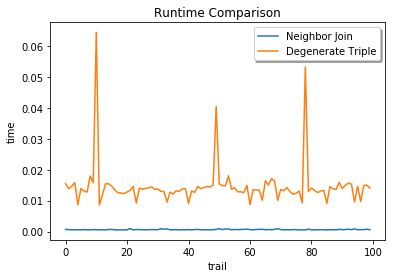

In [109]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(100)
l1, = ax.plot(x, nj_runtimes)
l2, = ax.plot(x, dt_runtimes)

ax.legend((l1, l2), ('Neighbor Join', 'Degenerate Triple'), loc='upper right', shadow=True)

#plt.plot(nj_runtimes)
#plt.plot(dt_runtimes)

ax.set_xlabel('trail')
ax.set_ylabel('time')
ax.set_title('Runtime Comparison')

plt.show()

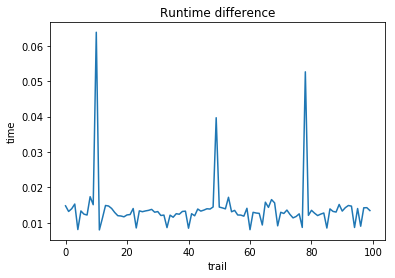

In [118]:
fig, ax = plt.subplots()
x = np.arange(100)
y = [i - j for i,j in zip(dt_runtimes, nj_runtimes)]
l1, = ax.plot(x, y)

#plt.plot(nj_runtimes)
#plt.plot(dt_runtimes)

ax.set_xlabel('trail')
ax.set_ylabel('time')
ax.set_title('Runtime difference')

plt.show()